In [79]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from tqdm import tqdm

from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=100
RANDSTATE = 42

sns.set(rc = {'figure.figsize':(13,8)})

# Preprocessing

In [16]:
df = pd.read_csv("VENUS_current_data.csv")
df.describe()

,trial index,file index,block index,beam_avg,beam_std,inj_avg,inj_std,ext_avg,ext_std,mid_avg,mid_std,bias_avg,bias_std,inj_p_avg,inj_p_std,ext_p_avg,ext_p_std
count,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1.565000e+03,1.565000e+03,1.565000e+03,1.565000e+03
mean,1.224920,12.230032,15.649840,156.411108,7.318653,124.539535,0.006922,102.803959,0.004496,101.341325,0.003195,4.463232,0.187529,1.093276e-07,4.623799e-10,8.052076e-09,9.514257e-11
std,0.818905,6.301219,9.493843,54.616864,6.864685,3.341419,0.005264,3.757696,0.002659,3.629322,0.001782,0.833265,0.182806,6.135745e-09,3.051013e-09,3.687252e-09,7.051879e-10
min,0.000000,0.000000,0.000000,23.862232,0.378532,117.005536,0.000000,96.990714,0.000000,94.999643,0.000000,2.275170,0.012404,9.785179e-08,0.000000e+00,4.902241e-09,1.477867e-11
25%,1.000000,7.000000,7.000000,120.019741,2.130479,122.011786,0.004468,100.060000,0.002966,98.598750,0.001873,3.922495,0.046165,1.041250e-07,2.328536e-10,6.153966e-09,4.369642e-11
50%,1.000000,12.000000,16.000000,147.963161,4.308883,124.573448,0.005557,102.441034,0.004443,101.280000,0.003478,4.385876,0.114744,1.083966e-07,4.086186e-10,7.097500e-09,5.249752e-11
75%,2.000000,17.000000,24.000000,198.362862,11.320690,127.013929,0.007854,105.367679,0.005345,104.083750,0.004558,4.966493,0.273393,1.129643e-07,4.993502e-10,8.537500e-09,6.542866e-11
max,2.000000,25.000000,34.000000,280.606517,34.172754,130.036786,0.056671,110.003214,0.037604,110.000179,0.010710,7.691891,1.030986,1.314655e-07,1.202603e-07,9.509107e-08,2.391238e-08


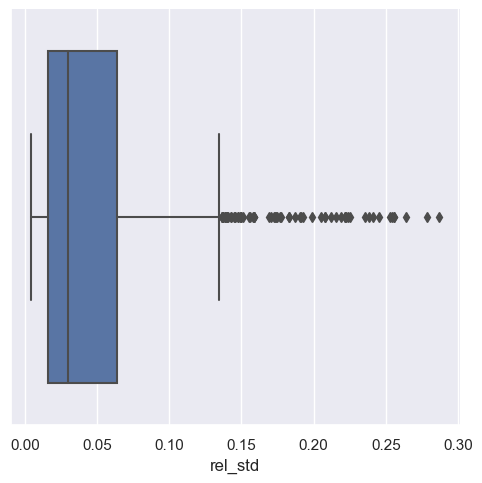

In [17]:
df["rel_std"] = df["beam_std"] / df["beam_avg"]
sns.catplot(x="rel_std", kind="box", data=df)

In [31]:
def extract_data(df, target="Data/"):
    # extracts the beam current and its relative variation from a dataframe to files
    exp_num_list = list(df["trial index"].unique()+1)
    for exp_num in exp_num_list:
        df["rel_std"] = df["beam_std"] / df["beam_avg"]
        data = df.loc[df['trial index'] == exp_num-1][["beam_avg", "beam_std", "inj_avg", "ext_avg", "mid_avg", "rel_std"]]

        beam_avg_arr = np.array(data["beam_avg"].to_list())
        beam_std_arr = np.array(data["rel_std"].to_list())

        xpts = data["mid_avg"].to_list()
        ypts = data["ext_avg"].to_list()
        zpts = data["inj_avg"].to_list()

        xpts, ypts, zpts, sizepts, magpts = xpts, ypts, zpts, [], list(beam_avg_arr)
        # Data saving sniphet from "Venus Data Exploration/Analyze Runs"
        data_list = [xpts, ypts, zpts, sizepts, magpts]
        target_file = "data%d.pkl"%exp_num
        open_file = open(target+target_file, "wb")
        pickle.dump(data_list, open_file)
        open_file.close()

        xpts, ypts, zpts, sizepts, magpts = xpts, ypts, zpts, [], list(beam_std_arr)
        # Data saving sniphet from "Venus Data Exploration/Analyze Runs"
        data_list = [xpts, ypts, zpts, sizepts, magpts]
        target_file = "std_data%d.pkl"%exp_num
        open_file = open(target+target_file, "wb")
        pickle.dump(data_list, open_file)
        open_file.close()

extract_data(df)

# Gaussian Process Regression

## Definitons

In [61]:
class MyDataset():
    def __init__(self, train_X, valid_X, train_y, valid_y, X_test = None):
        self.X_train = train_X
        self.y_train = train_y
        self.X_valid = valid_X
        self.y_valid = valid_y
        self.X_test = X_test
        
        self.normalized = False
        
    def __str__(self):
        return str((self.train_X.shape, self.train_y.shape, self.valid_X.shape, self.valid_y.shape))

    def normalize(self):
        if self.normalized:
            print("already normalized!")
            return
        
        std_list = np.std(self.X_train, axis=0)
        std_list = np.where(std_list == 0, 1, std_list) # prevent zero division error
        avg_list = np.mean(self.X_train, axis=0)
        self.X_train = (self.X_train - avg_list)/std_list
        if not self.X_valid is None: self.X_valid = (self.X_valid - avg_list)/std_list
        if not self.X_test is None: self.X_test = (self.X_test - avg_list)/std_list
            
        self.std_list = std_list
        self.avg_list = avg_list
        print("dataset normalized!")
        self.normalized = True
        return
    
    def normalize_vec(self, X):
        if not self.normalized:
            print("Dataset never normalized")
        return (X - self.avg_list)/self.std_list
    
    def add_fict(self):
        add_ones = lambda X: np.hstack((X,np.ones((X.shape[0],1))))
        self.X_train = add_ones(self.X_train)
        self.X_valid = add_ones(self.X_valid)
        self.X_test = add_ones(self.X_test)
        print("ficticious dimension added!")
        
    def print_dim(self):
        print("X_train has shape:",self.X_train.shape)
        print("y_train has shape:",self.y_train.shape)
        print("X_valid has shape:",self.X_valid.shape)
        print("y_valid has shape:",self.y_valid.shape)
        if self.X_test: print("X_test has shape:",self.X_test.shape)
    
def loadXy(data_dir):
    with open(data_dir, "rb") as fp:   # Unpickling
        data_list = pickle.load(fp)

    xpts, ypts, zpts, _, magpts = data_list

    # check data
    assert(len(xpts)==len(ypts) and len(xpts)==len(zpts) and len(xpts)==len(magpts))

    # Transform the data into X, y form
    n = len(xpts)
    d = 3
    X = np.array([xpts, ypts, zpts]).T
    y = np.array(magpts)
    return X, y

def load_train(exp_num, verbose=3, alpha=0.15, nu=0.66, datafolder = "Data/"):
    datafile = "data%d.pkl"%exp_num
    datafile = datafolder + datafile

    X, y = loadXy(datafile)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=41) #!!! RANDSEED
    venus = MyDataset(X_train, X_valid, y_train, y_valid)
    if verbose&1:
        print("Experiment %d data loaded!"%exp_num)
        venus.print_dim()
        venus.normalize()
    
     # best value is 0.15
    kernel = Matern(nu=nu)
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=alpha).fit(venus.X_train, venus.y_train)

    # check
    if verbose&2:
        print("Train score: %f  "%gpr.score(venus.X_train, venus.y_train))
        print("Test score:  %f  "%gpr.score(venus.X_valid, venus.y_valid))
    
    return venus, gpr, X, y

## Tests

In [102]:
exp_num = 3

venus, gpr, X, y = load_train(exp_num, verbose=3)

Experiment 3 data loaded!
X_train has shape: (518, 3)
y_train has shape: (518,)
X_valid has shape: (222, 3)
y_valid has shape: (222,)
dataset normalized!
Train score: 0.971636  
Test score:  0.848345  


0.789675 for nu=0.200000
0.815547 for nu=0.333333
0.826330 for nu=0.466667
0.831285 for nu=0.600000
0.833486 for nu=0.733333
0.834243 for nu=0.866667
0.834196 for nu=1.000000
0.833688 for nu=1.133333
0.832915 for nu=1.266667
0.831991 for nu=1.400000


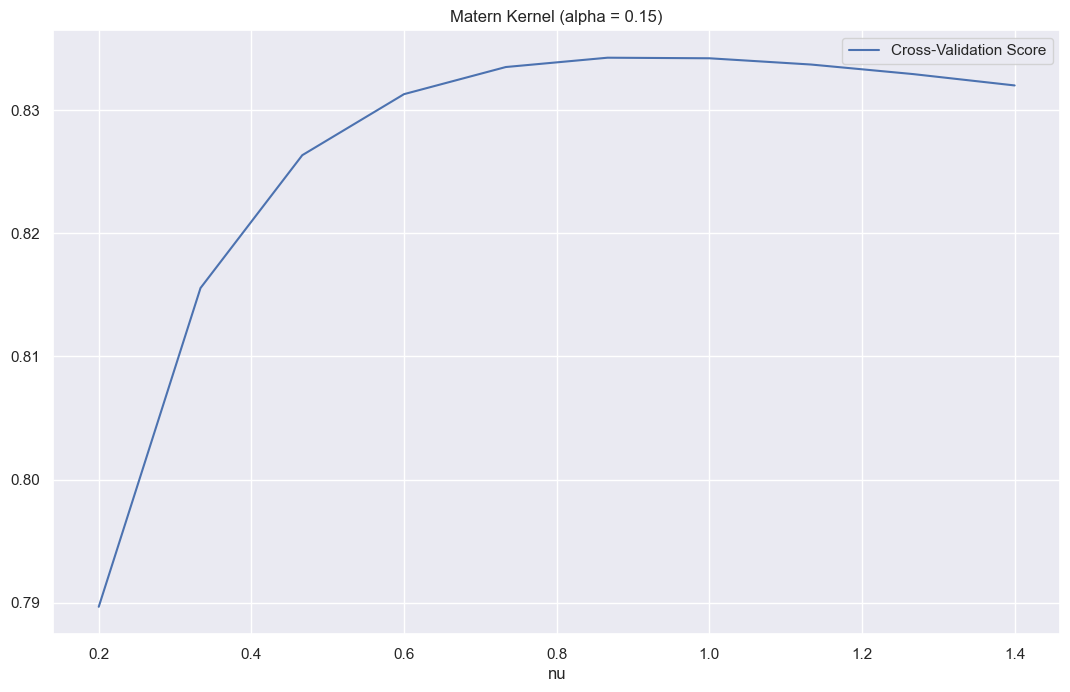

In [103]:
# Matern nu tuning
alpha = 0.15
cv_score = []
nus = np.linspace(0.2, 1.4, 10)
relu = lambda x: x if x>0 else 0
for nu in nus:
    kernel = Matern(nu=nu)
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, alpha=alpha).fit(venus.X_train, venus.y_train)
    cvs = cross_val_score(gpr, X, y)
    avg_cvs = sum(cvs)/len(cvs)
    print("%f for nu=%f"%(avg_cvs, nu))
    cv_score.append(avg_cvs)

cv_score = [relu(x) for x in cv_score]
plt.plot(nus, cv_score, label="Cross-Validation Score")
plt.legend()
plt.xlabel("nu")
plt.title("Matern Kernel (alpha = 0.15)")
plt.savefig("Matern nu exp%d.png"%exp_num)

In [105]:
# use all available data for the final model
kernel = Matern(nu=0.7)

venus_whole = MyDataset(X, None, y, None)
venus_whole.normalize()

gpr = GaussianProcessRegressor(kernel=kernel,random_state=1, alpha=alpha).fit(venus_whole.X_train, venus_whole.y_train)
print("Whole dataset training score: %f"%gpr.score(venus_whole.X_train, venus_whole.y_train))



# save the model and print the normalizing lists used
dumplist = [gpr, venus_whole.avg_list, venus_whole.std_list]
with open("Models/gpr_exp%d.dump"%exp_num , "wb") as f:
    pickle.dump(dumplist, f)
print(venus_whole.avg_list, venus_whole.std_list)

dataset normalized!
Whole dataset training score: 0.973478
[101.25973344 102.64066197 125.03169889] [3.81622632 3.82109588 3.32787807]


# Bayesian Optimization Simulation

## Definitions

In [68]:
class Venus:
    # note: always set the func paramter
    def __init__(
        self,
        inj_limits=[97, 110],
        mid_limits=[97, 110],
        ext_limits=[116, 128],
        beam_range=[0.50, 1.00],
        jitter=0, 
        func = (lambda X: -1)
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)
        self.func = func

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )

    def _rescale_output(self, output):
        """simple square returns values betwen 0 and 27 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 27.0) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )
    
    def get_noise_level(self):
        # return std of the noise
        noise = self.jitter*(self.beam_range[1] - self.beam_range[0])
        return noise

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return self.func(self.currents)

    @staticmethod
    def _simple_square(w, x, y):
        """A not so funky 3 dimensional parameter space with a single minima."""
        return (
            (w - 3.)**2 + (x - 3.)**2 + (y - 3.)**2
        )

## Tests

In [69]:
venus = Venus(jitter=0.15)

In [115]:
# import the function we are trying to optimize
def load_model(target):
    gpr_model, avg_list, std_list = pickle.load(open(target,"rb"))
    normalizer = lambda X: (X - avg_list )/ std_list
    func = lambda currents: gpr_model.predict(normalizer(currents.reshape(1, -1)))[0]
    return func
    
func1 = load_model("Models/gpr_exp1.dump") # the training func
func2 = load_model("Models/gpr_exp3.dump") # the test time func
print(func1(np.array([105,105,120])))
print(func2(np.array([105,105,120])))

81.67118720001949
144.220143932402


In [157]:
# kappa plotting
def try_kappa(kappa, bbf, n=10):
    best_list = []
    for i in range(n):
        random_state = int(i+100*kappa)
        optimizer = BayesianOptimization(f = bbf,
                                     pbounds = pbounds, verbose = 0,
                                     random_state = random_state)
        optimizer.maximize(init_points = 5, n_iter = 30, kappa=kappa, alpha=0.15)
        best = optimizer.max["target"]
        best_list.append(best)
    return best_list

100%|██████████████████████████████████████████| 10/10 [18:43<00:00, 112.33s/it]


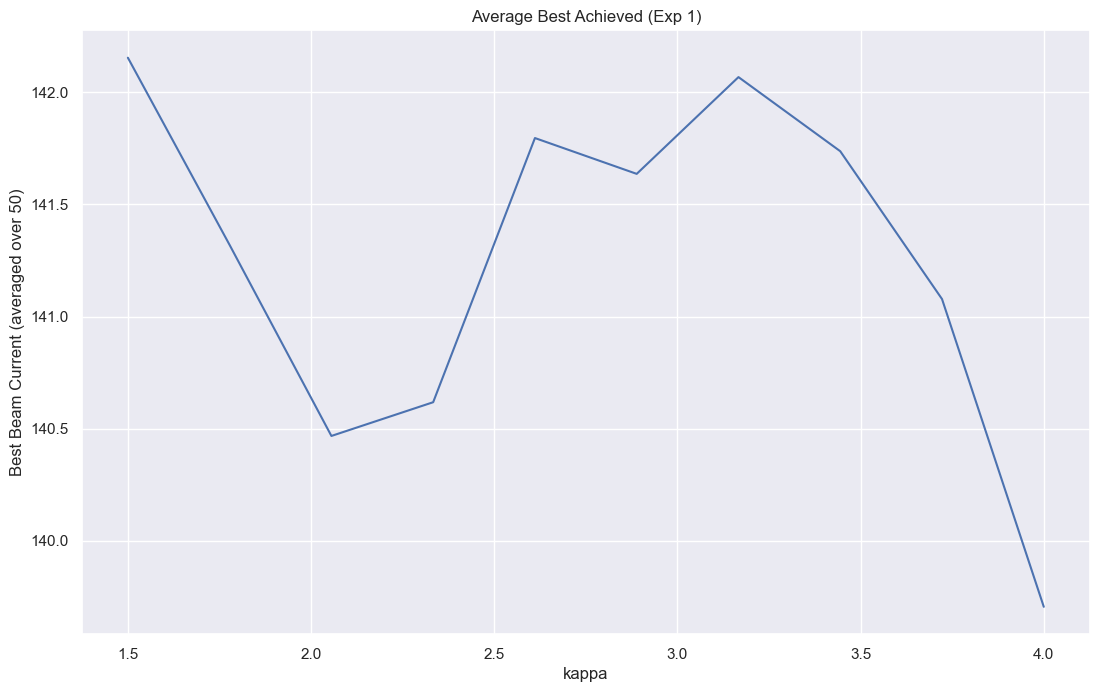

100%|██████████████████████████████████████████| 10/10 [17:43<00:00, 106.35s/it]


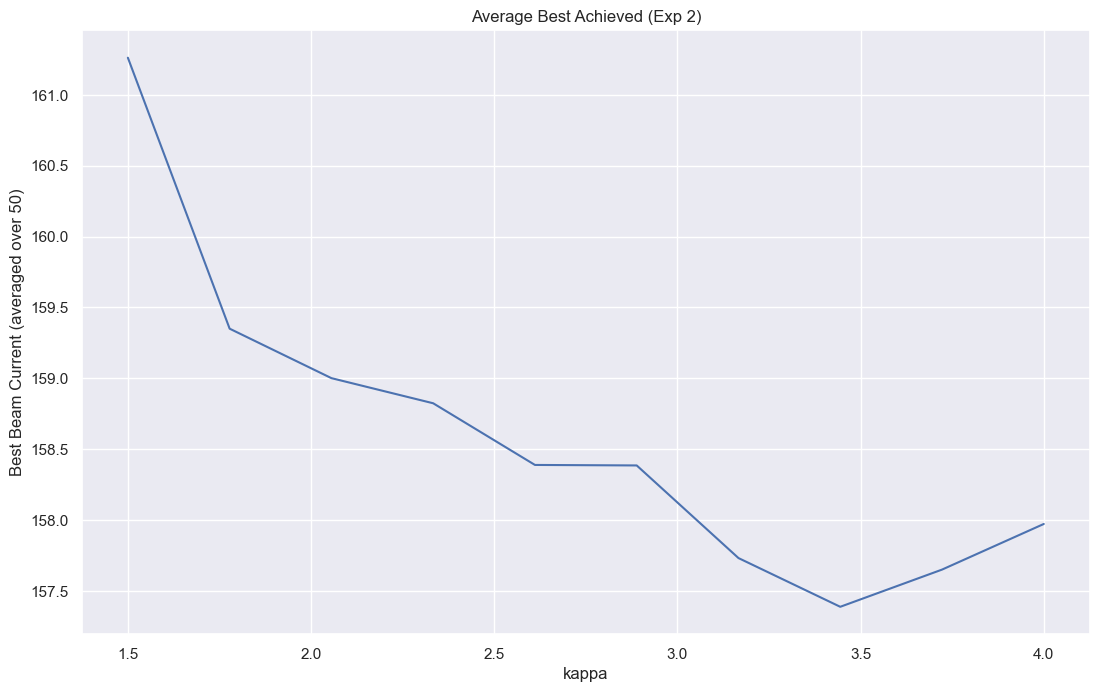

100%|██████████████████████████████████████████| 10/10 [18:52<00:00, 113.24s/it]


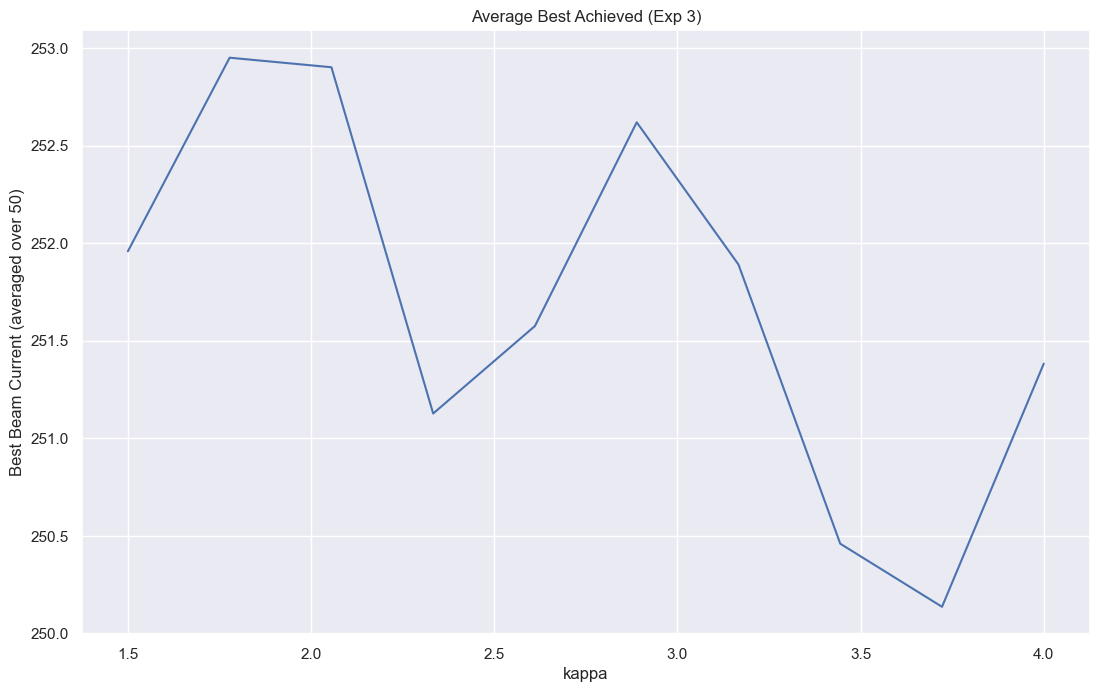

In [159]:
for exp_num in range(1,4):
    bbf = get_black_box_func(Venus(jitter=0.15, func=load_model("Models/gpr_exp%d.dump"%exp_num)))
    n = 50
    kappas = np.linspace(1.5, 4, 10)
    results = []
    for kappa in tqdm(kappas):
        best_list = try_kappa(kappa, bbf, n=n)
        results.append(sum(best_list)/len(best_list))

    plt.plot(kappas, results)
    plt.title("Average Best Achieved (Exp %d)"%exp_num)
    plt.xlabel("kappa")
    plt.ylabel("Best Beam Current (averaged over %d)"%n)
    plt.savefig("Exp %d kappa.png"%exp_num)
    plt.show()

In [112]:
def get_black_box_func(venus):
    # Define the black box function to optimize.
    def black_box_function(A, B, C):
        # C: SVC hyper parameter to optimize for.
        venus.set_mag_currents(A, B, C)
        v = venus.get_beam_current()
        return v
    return black_box_function

In [116]:
bbf1 = get_black_box_func(Venus(jitter=0.15, func=func1))
bbf2 = get_black_box_func(Venus(jitter=0.15, func=func2))

In [117]:
# now we try on the second run function but first probing the best paramter found from first run
def trial_probe(random_state):
    
    optimizer1 = BayesianOptimization(f = bbf1,
                                 pbounds = pbounds, verbose = 0,
                                 random_state = random_state)
    optimizer1.maximize(init_points = 0, n_iter = 80, kappa=2.3, alpha=0.15)
    best_params_found = optimizer1.max["params"]
    
    optimizer2 = BayesianOptimization(f = bbf2,
                                     pbounds = pbounds, verbose = 0,
                                     random_state = random_state)
    optimizer2.probe(
        params=best_params_found,
        lazy=True,
    )

    optimizer2.maximize(init_points = 0, n_iter = 10, kappa=0.3, alpha=0.15)
    # the second run best is around 170, so we define 150 as acceptable
    return optimizer2.max["target"]
results = []
for i in tqdm(range(100)):
    results.append(trial_probe(i))

100%|█████████████████████████████████████████| 100/100 [12:08<00:00,  7.29s/it]


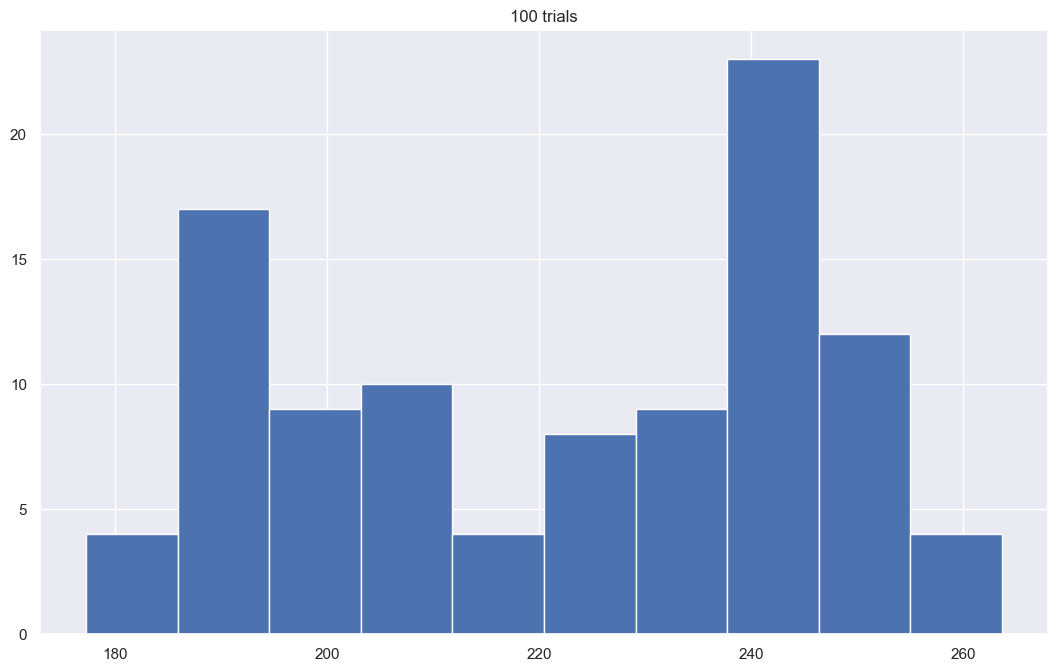

In [120]:
def trial2(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}
    noise = max(venus.get_noise_level(), 1e-5)
    
    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=noise) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    # print("Results:", results)
    n_succ = sum([i>=CUTOFF for i in results]) / len(results)
    return n_succ, results

def FairCoinVar(H, N):
    return (1 - H**2 + N + H * N)/((2 + N)**2 * (3 + N))
FairCoinVar(10, 100) ** (1/2)



0.030563159973920874